# Probolem
You are part of a research team of a FinTech company dedicated to forecast the price direction of public US companies. Using the dataset at VTIreturns.csv, you must build a forecasting model of the VTI (market index)'s next day's return (ret) and its direction using the years 2015-2019 to train and 2020-2021 to test your model. 

The file VTIreturns.csv includes the following variables:

ret: Vanguard Total Stock Market ETF daily return based on adjusted daily closing prices.

Lag1-Lag5: LagX is X-lagged value of ret

5 factors of the Fama French model:

RM-Rf : market return minus risk free rate (market risk premium)

SMB: Small Minus Big (firm size): difference of average return on 9 small and 9 big stock portfolios

HML: High Minus Low (value): difference of average return on 2 value and 2 growth portfolios 

RMW (Robust Minus Weak):  difference of average return on 2 robust and 2 weak operating profitability portfolios 

CMA (Conservative Minus Aggressive):  difference of average return on 2 conservative and 2 aggressive investment portfolios

For this exercise you do not need to know the details of the Fama French model. However, further details and data can be obtained at:
http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html




## 1.  Reading the csv file. Sorting the variables by date in a new dataset. Lising the names of the variables in the dataset.


In [50]:
#importing packages
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
import itertools
import time
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix, classification_report, precision_score,mean_squared_error
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



from sklearn import metrics

#Reading the data in a dataframe
df = pd.read_csv('VTIreturns.csv')
#print(df.head())

#Listing the names of variables
col_names = df.columns
print('The column names are:\n')
print(col_names)

#Converting date from string to date time format
df['Date'] = pd.to_datetime(df['Date'])

#Sorting by date
df_sort_date = df.sort_values(by = 'Date')

The column names are:

Index(['Date', 'ret', 'RM-Rf', 'SMB', 'HML', 'RMW', 'CMA', 'Lag1', 'Lag2',
       'Lag3', 'Lag4', 'Lag5'],
      dtype='object')


## 2. Generating a new variable ret1 which is the return of the next day and ret_sq which is squared of ret. 



In [51]:
#Creating a new column for squared returns
df_sort_date['ret_sq'] = df_sort_date['ret']*df_sort_date['ret']

#Initializing a new column 'ret1'
df_sort_date['ret1'] = math.nan

#Creating a new column for next day return
for i in range(0,df_sort_date.shape[0]):
    if i == df_sort_date.shape[0]-1:
        break
    
    #Picking up the next day value
    df_sort_date['ret1'].iloc[i] = df_sort_date['ret'].iloc[i+1]
    
df_sort_date.tail()   


/Users/priestleyfernandes/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,ret,RM-Rf,SMB,HML,RMW,CMA,Lag1,Lag2,Lag3,Lag4,Lag5,ret_sq,ret1
1534,2021-09-24,0.119389,0.08,-0.39,0.70,0.62,0.23,1.211179,1.003614,-0.008889,-1.748518,-0.804474,0.014254,-0.217969
1535,2021-09-27,-0.217969,-0.10,1.73,2.39,-0.27,0.76,0.119389,1.211179,1.003614,-0.008889,-1.748518,0.047511,-2.117043
1536,2021-09-28,-2.117043,-2.18,0.01,1.75,0.84,1.07,-0.217969,0.119389,1.211179,1.003614,-0.008889,4.481869,0.066844
1537,2021-09-29,0.066844,0.03,-0.18,0.80,1.15,0.35,-2.117043,-0.217969,0.119389,1.211179,1.003614,0.004468,-1.088358
1538,2021-09-30,-1.088358,-1.02,0.06,-0.77,-1.23,-0.34,0.066844,-2.117043,-0.217969,0.119389,1.211179,1.184523,NaN


## 3. Simple table of the means and standard deviations.



In [52]:
#Finding the mean of all coulumns
df_sort_date.loc['mean'] = df_sort_date.mean()

#Finding the standard deviation of all columns
df_sort_date.loc['std'] = df_sort_date.std()

#Creating a table of means and sds
df_mean_sd = df_sort_date.tail(2)


#Alternative tried
#df_mean_sd = pd.DataFrame(df.describe().loc['mean'],df.describe().loc['std'])
#print(df_mean_sd)

#Dropping the mean and sd rows for maintaining the structure of data
df_sort_date.drop(labels = ['mean','std'],inplace=True)

df_mean_sd

/var/folders/12/wrdf3scj0fb6r95lfqzfcbqr0000gn/T/ipykernel_32374/2490939138.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_sort_date.loc['mean'] = df_sort_date.mean()


,Date,ret,RM-Rf,SMB,HML,RMW,CMA,Lag1,Lag2,Lag3,Lag4,Lag5,ret_sq,ret1
mean,NaT,0.054173,0.056615,0.000884,-0.017186,0.009461,-0.004418,0.055126,0.054993,0.056435,0.055988,0.056716,1.389276,0.053794
std,646 days 13:26:04.246664456,1.177430,1.188686,0.694912,0.907436,0.455529,0.394136,1.177099,1.177109,1.175806,1.176040,1.176426,6.386126,1.177719


## 4. Exploring the distribution of the main variables of this dataset and the relationship with the variable return using graphs and/or statistical values. 



Descriptive statistics are as follows:
               ret        RM-Rf          SMB          HML          RMW  \
count  1539.000000  1539.000000  1539.000000  1539.000000  1539.000000   
mean      0.054173     0.056615     0.000884    -0.017186     0.009461   
std       1.177813     1.189073     0.695138     0.907731     0.455677   
min     -12.082221   -12.000000    -4.570000    -4.950000    -1.820000   
25%      -0.315907    -0.340000    -0.380000    -0.450000    -0.260000   
50%       0.078330     0.080000    -0.020000    -0.050000     0.000000   
75%       0.567944     0.580000     0.380000     0.390000     0.265000   
max       9.066106     9.340000     5.740000     6.750000     1.920000   

               CMA         Lag1         Lag2         Lag3         Lag4  \
count  1539.000000  1539.000000  1539.000000  1539.000000  1539.000000   
mean     -0.004418     0.055126     0.054993     0.056435     0.055988   
std       0.394264     1.177481     1.177492     1.176188     1.176423  

/Users/priestleyfernandes/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/priestleyfernandes/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/priestleyfernandes/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit 

                            OLS Regression Results                            
Dep. Variable:                   ret1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.430
Date:                Thu, 13 Oct 2022   Prob (F-statistic):              0.119
Time:                        21:06:06   Log-Likelihood:                -2432.7
No. Observations:                1538   AIC:                             4869.
Df Residuals:                    1536   BIC:                             4880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0537      0.030      1.790      0.0

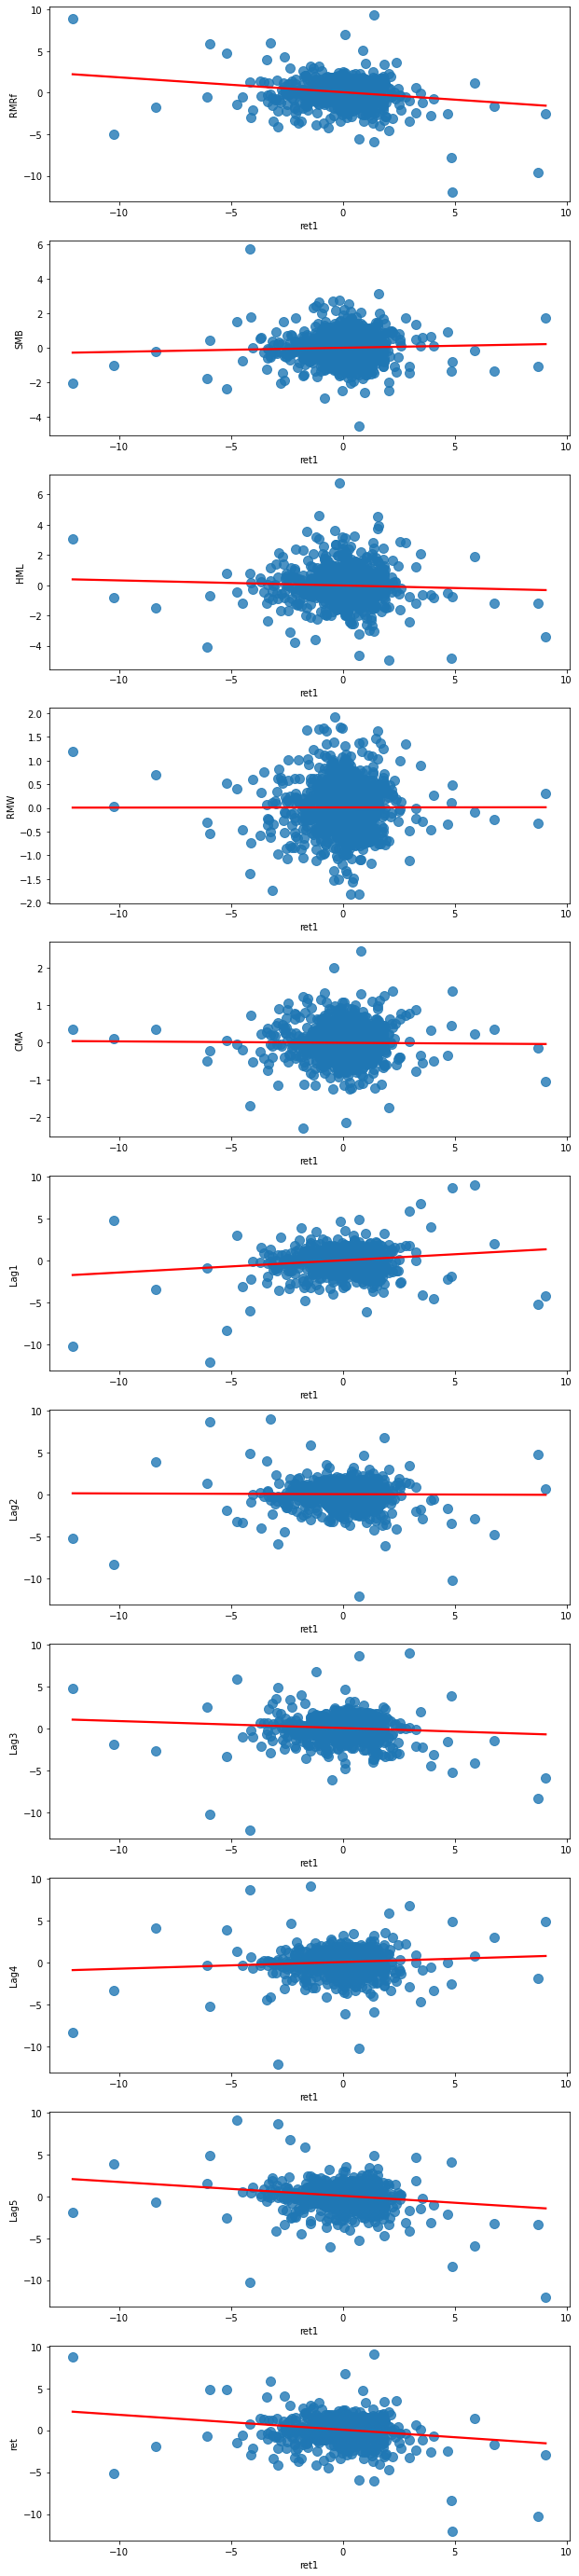

In [53]:
%matplotlib inline

#As per the question, assuming the main variables to be 'RM-Rf','SMB','HML','RMW','CMA'
#Thus, restricting the analyis to these variables

#Descriptive statsitics of the data
print("Descriptive statistics are as follows:")
print(df_sort_date.describe(),'\n')


#For simplicity creating a column for RM-Rf as RMRf
df_sort_date['RMRf'] = df_sort_date['RM-Rf']


#plotting graphs
main_variables = ['RMRf','SMB','HML','RMW','CMA','Lag1','Lag2','Lag3','Lag4','Lag5','ret']

#Creating a structure to accomodate subpplots for 11 variables
fig, axs = plt.subplots(nrows= 11,figsize=(10,50))


count = 0
for i in main_variables:
    sns.regplot('ret1', i, df_sort_date, line_kws = {"color":"r"}, ci=None,ax = axs[count])
    print('\n')
    count = count+1

for i in main_variables:
    
    lm = sm.OLS.from_formula('ret1 ~ '+i, df_sort_date)
    result = lm.fit()
    print(result.summary())
    



#Results Discussion

1.From descriptive statsistics it can be observed that data is from 2015 to 2021. Most of the variables related to returns have a reasonable standard deviation. All return derived parameters lie have a average mean of 0.05. 
2.The important parameters like 'RMRf','SMB','HML','RMW' and 'CMA'have a tighter spread as can be seen from the variances except RM-Rf.
3.On conducting the univariate analysis it can be clearly observed that next day return is slightly negatively correlated with current day return. The primary variables like 'SMB','HML','RMW' and 'CMA' seem to be weakly correlated indicating lesser impact as can be seen from their lower R2 values and higher AIC and BIC values. 
4.Even lags dont seem to be having a major impact on determining the course of returns with highest correlation observed with 5 day lag(negative) and 1 day lag(positive).
RM-Rf is also slightly negtaively affecting the next day returns.
5.Out of all factors, RM-Rf and past day returns seem to have a major influence 

## Spliting data into a training set (until 2019) and a testing set (2020-21). Using the training sample, regressing next day return on the remaining variables (removing DATE).

In [54]:
#Fetching year from date
df_sort_date['year'] = pd.to_datetime(df_sort_date['Date']).dt.year

#Splitting data into training data and testing data

#Fetching training data
df_train_lm = df_sort_date[df_sort_date['year']<=2019]


#Fetching testing data
df_test_lm = df_sort_date[df_sort_date['year'].between(2020,2021)]


#Creating a multivariate model with ret1 as next dat return
lm = sm.OLS.from_formula('ret1 ~ ' + '+'.join(df_train_lm.columns.difference(['ret1','Date','year','RM-Rf'])), df_train_lm)
result = lm.fit()

#Viewing the result
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ret1   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9725
Date:                Thu, 13 Oct 2022   Prob (F-statistic):              0.473
Time:                        21:06:20   Log-Likelihood:                -1394.8
No. Observations:                1102   AIC:                             2816.
Df Residuals:                    1089   BIC:                             2881.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0432      0.030      1.458      0.145      -0.015       0.101
CMA           -0.0675      0.099     -0.680      0.496      -0.262       0.127
HML           -0.0392      0.057     -0.694      0.488      -0.150       0.072
Lag1          -0.0410      0.031     -1.324      0.186      -0.102       0.020
Lag2           0.0226      0.031      0.730      0.465      -0.038       0.083
Lag3          -0.0406      0.031     -1.324      0.186      -0.101       0.020
Lag4          -0.0265      0.031     -0.864      0.388      -0.087       0.034
Lag5          -0.0003      0.030     -0.010      0.992      -0.060       0.059
RMRf          -0.9585      0.500     -1.916      0.056      -1.940       0.023
RMW            0.0208      0.078      0.268      0.789      -0.132       0.173
SMB            0.0674      0.053      1.270      0.204      -0.037       0.172
ret            0.9640      0.509      1.892      0.059      -0.036       1.964
ret_sq         0.0086      0.017      0.519      0.604      -0.024       0.041
==============================================================================
Omnibus:                      175.569   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.690
Skew:                          -0.704   Prob(JB):                    4.74e-155
Kurtosis:                       6.673   Cond. No.                         54.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Printing a table showing what variables would be selected using best subset selection (minimizing RSS) for all predictors of the training set. Determine the optimal model using Mallows' Cp and output the model, including its coefficients.



In [55]:
# Using best subset selection

#Defining the dependent variable
y_train = df_train_lm['ret1']

#Creating a list of feature variables
X_train= df_train_lm.drop(['ret1','Date','year','RMRf'],axis=1)

#Defining the dependent variable for test sample
y_test = df_test_lm['ret1']

#Creating a list of feature variables for test sample
X_test= df_test_lm.drop(['ret1','Date','year','RMRf'],axis=1)


#Defining function for fitting model on feature set and calculating RSS
def ProcessSubset(feature_set):
    model = sm.OLS(y_train,X_train[list(feature_set)])
    reg = model.fit()
    RSS = ((reg.predict(X_train[list(feature_set)]) - y_train)**2).sum()
    return {'model':reg,'RSS':RSS}

#Initiating a list to capture RSS, number of features,model and feature list for calculating Mallow's Cp
RSS_list, model_list, feature_list = [],[], []
numb_features = []

#Defining the function to get best model
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    #Iterating on the all posible combinations 
    for combo in itertools.combinations(X_train.columns,k):
        results.append(ProcessSubset(combo))
        RSS_list.append(results[0]['RSS'])
        model_list.append(results[0]['model'])
        feature_list.append(combo)
        numb_features.append(k)
        
        
    # Wrap everything up in a nice dataframe
    #models = pd.DataFrame(results)
    
    models = pd.DataFrame({"RSS":RSS_list,"Model":model_list,"Feature list":feature_list,"Number of features":numb_features})
   
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [56]:
#Creating a table of all relevant parameters
df_model_best = pd.DataFrame(columns=["RSS","Model","Feature list","Number of features"])

#Applying the 
tic = time.time()
for i in range(1,13):
    df_model_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

#Printing the best model
df_model_best

Processed 12 models on 1 predictors in 0.0307919979095459 seconds.
Processed 78 models on 2 predictors in 0.10084795951843262 seconds.
Processed 298 models on 3 predictors in 0.35385990142822266 seconds.
Processed 793 models on 4 predictors in 0.8662087917327881 seconds.
Processed 1585 models on 5 predictors in 1.3095459938049316 seconds.
Processed 2509 models on 6 predictors in 2.4062631130218506 seconds.
Processed 3301 models on 7 predictors in 1.425682783126831 seconds.
Processed 3796 models on 8 predictors in 0.8551480770111084 seconds.
Processed 4016 models on 9 predictors in 0.4682800769805908 seconds.
Processed 4082 models on 10 predictors in 0.16234588623046875 seconds.
Processed 4094 models on 11 predictors in 0.054913997650146484 seconds.
Processed 4095 models on 12 predictors in 0.031717777252197266 seconds.
Total elapsed time: 8.105134010314941 seconds.


,RSS,Model,Feature list,Number of features
1,822.077824,<statsmodels.regression.linear_model.Regressio...,"(ret,)",1
2,820.502113,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf)",2
3,819.751550,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB)",3
4,818.146214,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB, HML)",4
5,818.031543,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB, HML, RMW)",5
6,817.650381,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB, HML, RMW, CMA)",6
7,816.354923,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB, HML, RMW, CMA, Lag1)",7
8,815.885331,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB, HML, RMW, CMA, Lag1, Lag2)",8
9,814.591425,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB, HML, RMW, CMA, Lag1, Lag2, L...",9
10,814.032950,<statsmodels.regression.linear_model.Regressio...,"(ret, RM-Rf, SMB, HML, RMW, CMA, Lag1, Lag2, L...",10


Text(0, 0.5, 'BIC')

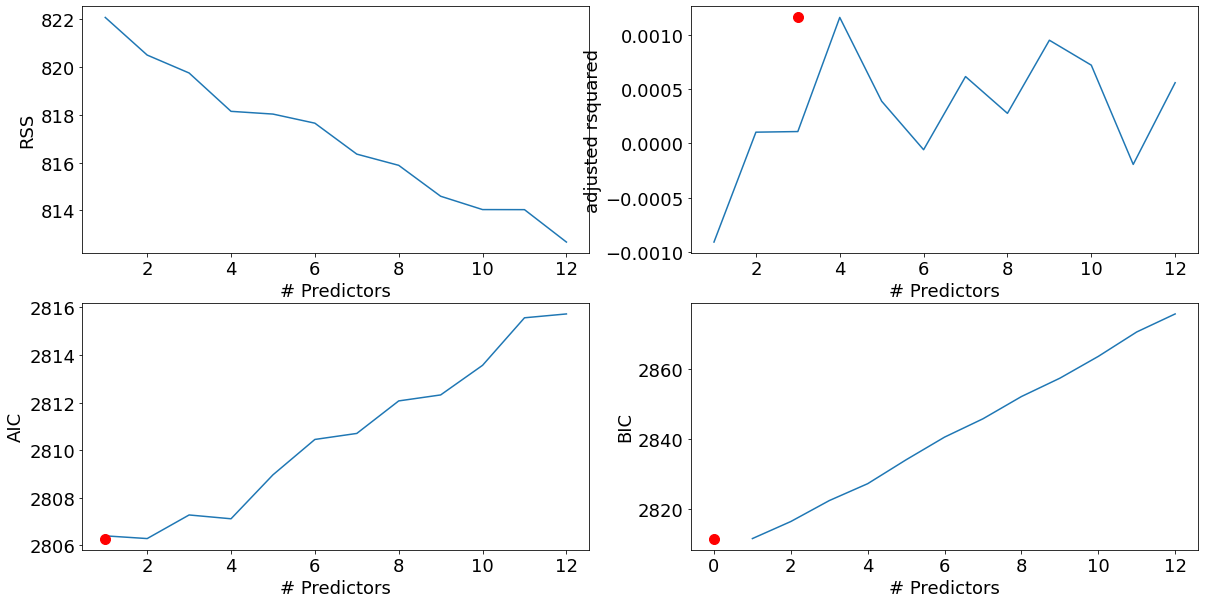

In [57]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(df_model_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = df_model_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
#
# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = df_model_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')
#
bic = df_model_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [58]:
#Cp calculation and choosing model based on least Cp value

##Initializing useful variables
#m = len(y)
#p = X.shape[1]
#hat_sigma_squared = (1/(m - p -1)) * min(df_model_best['RSS'])
#
##Computing
#df_model_best['C_p'] = (1/m) * (df_model_best['RSS'] + 2 * df_model_best['Number of features'] * hat_sigma_squared )

#Getting index of the optimal model based on least Cp value
#best_model_id = (pd.to_numeric(df_model_best['C_p'])).argmin()
#best_model_id = (pd.to_numeric(df_model_best['Model'][1].bic)).argmin()

#Calculating AIC as an equivalent of markow's cp as advised by professor
aic = df_model_best.apply(lambda row: row[1].aic, axis=1)
df_model_best['AIC'] = aic

#Getting index of the optimal model based on least AIC value
best_model_id = (pd.to_numeric(df_model_best['AIC'])).argmin()

#Printing the result and co-efficients 
print(best_model_id)
print("------------")
print("Best Subset:")
print("------------")
print(df_model_best.loc[best_model_id +1, "Model"].summary())
print(df_model_best.loc[best_model_id +1, "Model"].params)


1
------------
Best Subset:
------------
                                 OLS Regression Results                                
Dep. Variable:                   ret1   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.057
Date:                Thu, 13 Oct 2022   Prob (F-statistic):                       0.348
Time:                        21:06:36   Log-Likelihood:                         -1401.1
No. Observations:                1102   AIC:                                      2806.
Df Residuals:                    1100   BIC:                                      2816.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]


## Printing a table showing what variables would be selected using forward subset selection (minimizing RSS) for all predictors of the training set. Determine the optimal model using BIC and output the model, including its coefficients.

In [59]:
#Using Forward subset selection
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(ProcessSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model





In [60]:
#Applying the forward subset selection function
df_models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

#Applying the forward subest sleection function
for i in range(1,len(X_train.columns)+1):    
    df_models_fwd.loc[i] = forward(predictors)

    predictors = df_models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

#Extracting the bic and creating a column for BIC in original table
bic = df_models_fwd.apply(lambda row: row[1].bic, axis=1)
df_models_fwd['BIC'] = bic

#Getting index of the optimal model based on least BIC value
best_model_id_fwd = (pd.to_numeric(df_models_fwd['BIC'])).argmin()

#Printing the result and co-efficients 
print("------------")
print("Best Forward selection:")
print("------------")
print(df_models_fwd.loc[best_model_id_fwd +1, "model"].summary())
print(df_models_fwd.loc[best_model_id_fwd+1, "model"].params)



Processed  12 models on 1 predictors in 0.029203176498413086 seconds.
Processed  11 models on 2 predictors in 0.02493000030517578 seconds.
Processed  10 models on 3 predictors in 0.020692110061645508 seconds.
Processed  9 models on 4 predictors in 0.027289152145385742 seconds.
Processed  8 models on 5 predictors in 0.021943092346191406 seconds.
Processed  7 models on 6 predictors in 0.016030073165893555 seconds.
Processed  6 models on 7 predictors in 0.011996984481811523 seconds.
Processed  5 models on 8 predictors in 0.007085084915161133 seconds.
Processed  4 models on 9 predictors in 0.006118059158325195 seconds.
Processed  3 models on 10 predictors in 0.005871772766113281 seconds.
Processed  2 models on 11 predictors in 0.004172801971435547 seconds.
Processed  1 models on 12 predictors in 0.002871990203857422 seconds.
Total elapsed time: 0.19565606117248535 seconds.
------------
Best Forward selection:
------------
                                 OLS Regression Results             

Text(0, 0.5, 'BIC')

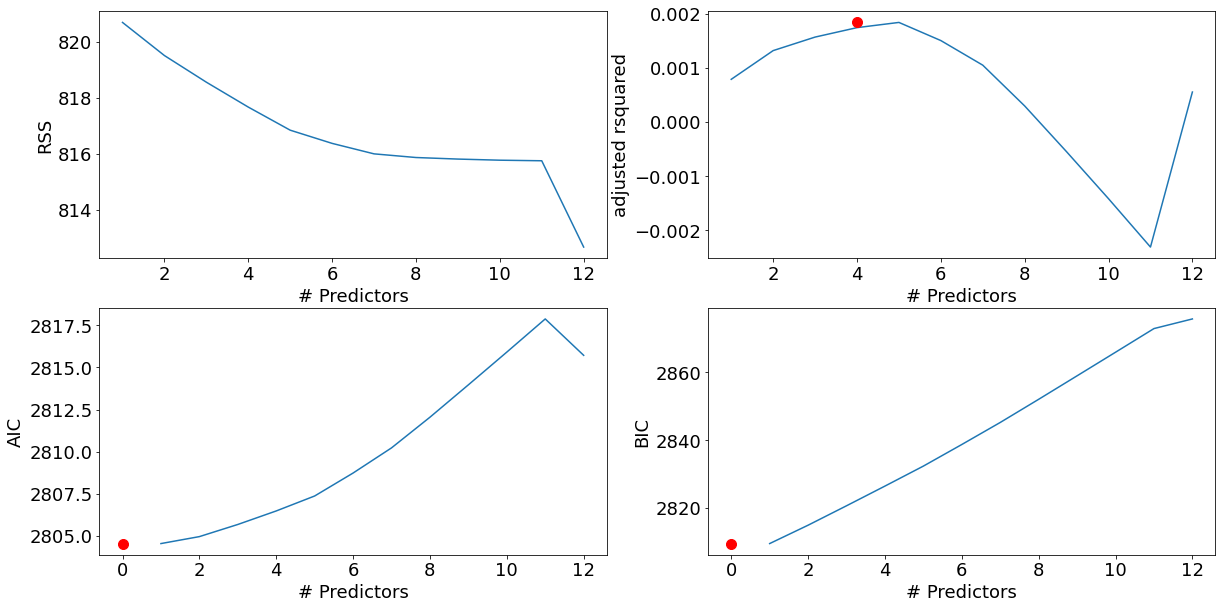

In [61]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(df_models_fwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = df_models_fwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
#
# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = df_models_fwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')
#
bic = df_models_fwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

### Printing a table showing what variables would be selected using backward subset selection (minimizing RSS) for all predictors of the training set. Determine the optimal model using R^2 and output the model, including its coefficients.



In [62]:
#Using Backward subset selection
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(ProcessSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model



In [63]:
#Applying backward subset selection
df_models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X_train.columns)))

tic = time.time()

#Initiating the predictors icluding all columns
predictors = X_train.columns

#Applying backward subset selection with simultaneous removal of feature at each step
while(len(predictors) > 1):  
    df_models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = df_models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

#Extracting R2 and creating a column for R2 in original table
R2 = df_models_bwd.apply(lambda row: row[1].rsquared, axis=1)
df_models_bwd['R-square'] = R2

#Getting index of the optimal model based on max R-square value
best_model_id_bwd = pd.to_numeric(df_models_bwd['R-square']).argmax()

#Printing the result and co-efficients 
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(df_models_bwd.loc[best_model_id_bwd +1, "model"].summary())
print(df_models_bwd.loc[best_model_id_bwd+1, "model"].params)

#Assesing all models

print(df_models_bwd.loc[7, "model"].summary())
print(df_models_bwd.loc[7, "model"].params)

print(df_models_bwd.loc[8, "model"].summary())
print(df_models_bwd.loc[8, "model"].params)

print(df_models_bwd.loc[9, "model"].summary())
print(df_models_bwd.loc[9, "model"].params)

print(df_models_bwd.loc[10, "model"].summary())
print(df_models_bwd.loc[10, "model"].params)


#Model 8 looks best if we consider all aspects


Processed  12 models on 11 predictors in 0.02333378791809082 seconds.
Processed  11 models on 10 predictors in 0.017300128936767578 seconds.
Processed  10 models on 9 predictors in 0.015478134155273438 seconds.
Processed  9 models on 8 predictors in 0.015099048614501953 seconds.
Processed  8 models on 7 predictors in 0.024246931076049805 seconds.
Processed  7 models on 6 predictors in 0.01935601234436035 seconds.
Processed  6 models on 5 predictors in 0.008408069610595703 seconds.
Processed  5 models on 4 predictors in 0.009032964706420898 seconds.
Processed  4 models on 3 predictors in 0.0069310665130615234 seconds.
Processed  3 models on 2 predictors in 0.0054171085357666016 seconds.
Processed  2 models on 1 predictors in 0.0029261112213134766 seconds.
Total elapsed time: 0.15349507331848145 seconds.
-------------------
Backward Selection:
-------------------
                                 OLS Regression Results                                
Dep. Variable:                   ret1 

Text(0, 0.5, 'BIC')

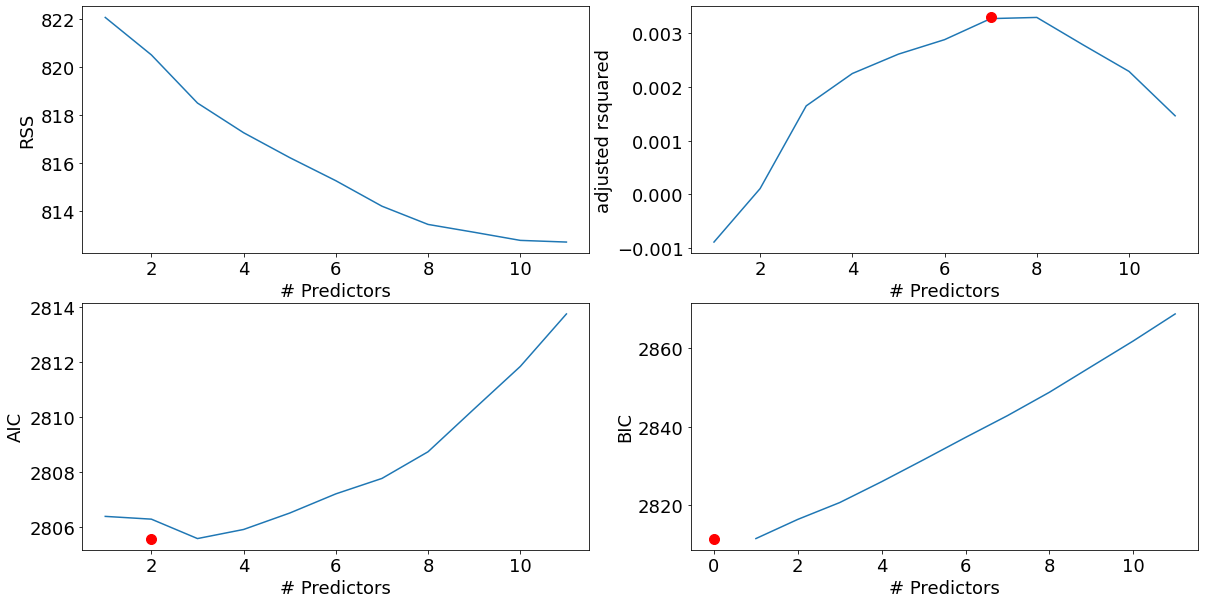

In [64]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(df_models_bwd["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = df_models_bwd.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')
#
# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = df_models_bwd.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')
#
bic = df_models_bwd.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

## Using the training sample, fitting a Ridge regression model with all the variables to forecast excess return.  Creating a graph with the diferent values of lambda and the coefficients. Fitting a Ridge regression model with a 10-fold cross-validation to choose the tuning parameter lambda. Printing the value of the coefficients. Using the best lambda and the test sample, predicting next day excess return and calculate the mean squared error.



Optimal alpha is:
 
3888888889.2790213
MSE for the 1st method adopted without ridgeCV is:

3.0127536681131395
Optimal alpha is:

5000000000.0
MSE for the 2nd method adopted with lassoCV is:

3.012753668111989
ret      -7.373289e-13
RM-Rf    -1.260140e-12
SMB       7.365334e-12
HML      -1.217640e-11
RMW       3.704961e-12
CMA      -1.532532e-11
Lag1     -8.194431e-12
Lag2      4.793579e-12
Lag3     -8.399537e-12
Lag4     -5.848016e-12
Lag5      1.770751e-12
ret_sq    1.972939e-12
dtype: float64


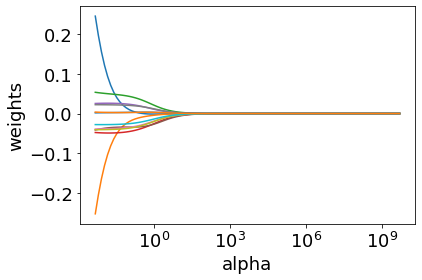

In [65]:
#Ridge Regression

alphas = 10**np.linspace(10,-2,100)*0.5

#Normalizing the data
ridge = Ridge(normalize=True)
coefs = []

#Running the ridge regression for different values of alpha and collecting co-efficient's data
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    


#Plotting the variation of co-efficient value for each feature with alpha
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

#Comparing two approaches using K fold(no ridgeCV) and with ridgeCV

#Method 1 without ridgeCV
#Splitting data into 10 folds
df_ridge = np.split(df_train_lm.iloc[len(df_train_lm)%10:df_train_lm.shape[0],0:df_train_lm.shape[1]],10,axis=0)

#Initiating list to store best alphas(minimizing error) for each iteration
best_alpha_list = []
for i in range(0,len(df_ridge)-1):
    alpha_list = []
    mse_list = []
    
    #Splitting time series data such that consecutive folds become training and test sets respectively
    X_ridge_train = df_ridge[i].drop(['Date','year','RMRf','ret1'],axis=1)
    y_ridge_train = df_ridge[i]['ret1']
    X_ridge_test = df_ridge[i+1].drop(['Date','year','RMRf','ret1'],axis=1)
    y_ridge_test = df_ridge[i+1]['ret1']
    for j in alphas:
        ridge.set_params(alpha=j)
        ridge.fit(X_ridge_train, y_ridge_train)
        pred_ridge = ridge.predict(X_ridge_test)
        mse = mean_squared_error(y_ridge_test, ridge.predict(X_ridge_test))
        alpha_list.append(j)
        mse_list.append(mse)
        
        #Create a dict of mse and corresponding alpha
        alpha_mse = {'alpha':alpha_list,'mse':mse_list}
        
    alpha_mse_df = pd.DataFrame(alpha_mse)
    alpha_mse_df.set_index('alpha')
    #print(alpha_mse_df)
    
    #Selecting alpha with minimum mse
    best_alpha = alpha_mse_df['alpha'][alpha_mse_df['mse'].argmin()]
    best_alpha_list.append(best_alpha)
#Taking the average 
avg_best_alpha = (np.array(best_alpha_list)).sum()/(len(df_ridge)-1)


#Running ridge regression 
ridge = Ridge(alpha=avg_best_alpha, normalize=True)
ridge.fit(X_train, y_train)


print("Optimal alpha is:\n ")
print(avg_best_alpha)
mse1 = mean_squared_error(y_test[0:len(y_test)-1], ridge.predict(X_test[0:len(X_test)-1]))
print('MSE for the 1st method adopted without ridgeCV is:\n')
print(mse1)


#Method 2 with ridgeCV

#Using ridgeCV with k= 10 fold for finding optimal alpha
ridgecv = RidgeCV(alphas=alphas, normalize=True, cv = 10, scoring=None) #'mean_squared_error'
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

    
##Using the value of optimal alpha to find the fitted line and coressponding predicted values
ridge = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge.fit(X_train, y_train)
#
#print(ridge.predict(X_test))
#

print("Optimal alpha is:\n")
print(ridgecv.alpha_)
##Finding MSE
mse2 = mean_squared_error(y_test[0:len(y_test)-1], ridge.predict(X_test[0:len(X_test)-1]))
print('MSE for the 2nd method adopted with lassoCV is:\n')
print(mse2)
print(pd.Series(ridge.coef_,index=X_train.columns))


### Fit a Lasso regression model with a 10-fold cross-validation to choose the tuning parameter lambda. Print the value of the coefficients. Using the best lambda and the test sample, predict next day excess return and calculate the mean squared error.



           alpha      mse
0   5.000000e+09  0.89617
72  9.369087e+00  0.89617
71  1.238538e+01  0.89617
70  1.637275e+01  0.89617
69  2.164381e+01  0.89617
..           ...      ...
28  2.018509e+06  0.89617
27  2.668350e+06  0.89617
26  3.527401e+06  0.89617
36  2.164381e+05  0.89617
99  5.000000e-03  0.89617

[100 rows x 2 columns]
           alpha       mse
0   5.000000e+09  0.378247
72  9.369087e+00  0.378247
71  1.238538e+01  0.378247
70  1.637275e+01  0.378247
69  2.164381e+01  0.378247
..           ...       ...
28  2.018509e+06  0.378247
27  2.668350e+06  0.378247
26  3.527401e+06  0.378247
36  2.164381e+05  0.378247
99  5.000000e-03  0.378247

[100 rows x 2 columns]
           alpha       mse
0   5.000000e+09  0.221707
72  9.369087e+00  0.221707
71  1.238538e+01  0.221707
70  1.637275e+01  0.221707
69  2.164381e+01  0.221707
..           ...       ...
28  2.018509e+06  0.221707
27  2.668350e+06  0.221707
26  3.527401e+06  0.221707
36  2.164381e+05  0.221707
99  5.000000e-03  0

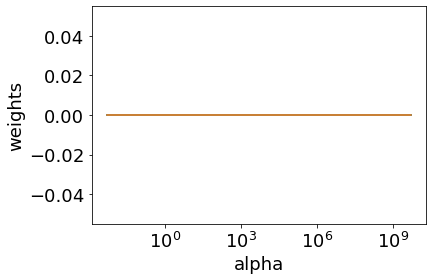

In [66]:
#Lasso regression

lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

#Finding values for different values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)


#Plotting variation of co-efficient value for each feature with alpha(Lasso)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

#Comparing two approaches using K fold(no lassoCV) and with lassoCV

#Method 1 without lassoCV
df_lasso = np.split(df_train_lm.iloc[len(df_train_lm)%10:df_train_lm.shape[0],0:df_train_lm.shape[1]],10,axis=0)

#Initiating list to store best alphas(minimizing error) for each iteration
best_alpha_list = []
for i in range(0,len(df_lasso)-1):
    alpha_list = []
    mse_list = []
    #Splitting time series data such that consecutive folds become training and test sets respectively
    X_lasso_train = df_lasso[i].drop(['Date','year','RMRf','ret1'],axis=1)
    y_lasso_train = df_lasso[i]['ret1']
    X_lasso_test = df_lasso[i+1].drop(['Date','year','RMRf','ret1'],axis=1)
    y_lasso_test = df_lasso[i+1]['ret1']
    for j in alphas:
        lasso.set_params(alpha=j)
        lasso.fit(X_lasso_train, y_lasso_train)
        pred_lasso = lasso.predict(X_lasso_test)
        mse = mean_squared_error(y_lasso_test, ridge.predict(X_lasso_test))
        alpha_list.append(j)
        mse_list.append(mse)
        
    #Create a dict of mse and corresponding alpha
    alpha_mse = {'alpha':alpha_list,'mse':mse_list}
    alpha_mse_df = pd.DataFrame(alpha_mse)
    
    #plt.plot(alpha_mse_df['alpha'],alpha_mse_df['mse'])
    
    alpha_mse_df.set_index('alpha')
    #print(alpha_mse_df)
    
    #Selecting alpha with minimum mse
    best_alpha = alpha_mse_df['alpha'][alpha_mse_df['mse'].argmin()]
    best_alpha_list.append(best_alpha)
    print(alpha_mse_df.sort_values('mse'))

#Taking the average 
avg_best_alpha = (np.array(best_alpha_list)).sum()/(len(df_lasso)-1)


#Running lasso regression
lasso = Lasso(alpha=avg_best_alpha, normalize=True)
lasso.fit(X_train, y_train)

print("Optimal alpha is:\n ")
print(avg_best_alpha)
mse3 = mean_squared_error(y_test[0:len(y_test)-1], lasso.predict(X_test[0:len(X_test)-1]))
print('MSE for the 1st method adopted without ridgeCV is:\n')
print(mse3)


#Method 2 with lassoCV

#Finding optimal alpha
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=1000, normalize=True)
lassocv.fit(X_train, y_train)

#Fitting the linen and predicting the values 
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)


print("Optimal alpha is:\n")
print(lassocv.alpha_)
#Finding the MSE value
mse4 = mean_squared_error(y_test[0:len(y_test)-1], lasso.predict(X_test[0:len(X_test)-1]))
print('MSE for the 2nd method adopted with lassoCV is:\n')
print(mse4)


print(pd.Series(lasso.coef_,index=X_train.columns))
#predict next day excess return #####

##  From the results, it is evident that both ridge regression and lasso regression, try to regulaize the regression parameters by penalizing coeffiecients which tend to deviate output from true output values. 
## Both ridge regression and lasso regression in this case are giving an MSE of 3.01275 indicating that there is no significant differnce created by both models even if lasso is a more aggressive approach because of multiple iterations it goes through. 
##  lasso has a tendency of feature reduction, in this problem, all the co-efficients are tending towrads 0 which means that intercept alone is acting as a factor. This can lead to overfitting and thus lead to wrong predictions. 
## The ideal alpha value chosen for least MSE is identidfied as 5000000000 which is very high.
##  MSE is found to be 3.0125. 
## An interesting observation which can be made is that, since it is a time series model, its predictive ability is varying with the K value (fold) . At different time frames the values are different for MSE but constant for all values of alpha. This can be explicitly shown in case of lasso regression in the output provided. Thus, the mse value seems to be independent of alpha. 
## Therefore, in order to account for a robust model without overfitting issues, ridge model can be used. Although, for this time series problem, any simpler approach can give moderate  results since there is lack of correlation due to a lot of variance present in the original data.



# Creating another field "Direction" in this data frame that looks to the direction of the return of the next period (ret1). After "Direction" is created, ret1 should not be included in the dataset.
  
## Using the training set, run LDA to forecast "Direction."  Predict with the test sample. Calculate the confusion matrix and accuracy.

In [67]:
#Importing libraries
%matplotlib inline

df_sort_date['Direction'] = df_sort_date['ret1']-df['ret']


for i in range(0,len(df_sort_date['Direction'])):
    
    if pd.to_numeric(df_sort_date['Direction'].iloc[i]) >= 0:
        df_sort_date['Direction'].iloc[i] = "UP"
    else:
        df_sort_date['Direction'].iloc[i] = "DOWN"
            
df_new = df_sort_date.drop(columns = ['ret1'])     

print(df_new)

#Converting into 1 and 0
df_new['Direction'].replace(['UP','DOWN'],[1,0],inplace=True)

#Splitting data into training data and testing data

#Fetching training data
df_train2 = df_new[df_new['year']<=2019]
df_train2.tail()

df_train2.head()

#Fetching testing data
df_test2 = df_new[df_new['year'].between(2020,2021)]
df_test2.tail()
df_test2.head()


#Defining the dependent variable
y2 = df_train2['Direction']
y_test = df_test2['Direction']

#Creating a list of feature variables
X2= df_train2.drop(['Date','year','RMRf','Direction'],axis=1)
X_test = df_test2.drop(['Date','year','RMRf','Direction'],axis=1)


lda = LDA()
model = lda.fit(X2, y2)
print(model.priors_)
print(model.means_)
print(model.coef_)

pred=model.predict(X_test)
print(np.unique(pred, return_counts=True))

print(confusion_matrix(pred, y_test))
print(classification_report(y_test, pred, digits=3))



                     Date       ret  RM-Rf   SMB   HML   RMW   CMA      Lag1  \
0     2015-08-17 00:00:00  0.635918   0.60  0.36 -0.85 -0.22 -0.37  0.379802   
1     2015-08-18 00:00:00 -0.257553  -0.35 -0.61  0.37  0.37  0.03  0.635918   
2     2015-08-19 00:00:00 -0.897452  -0.85 -0.20 -0.21 -0.10 -0.03 -0.257553   
3     2015-08-20 00:00:00 -2.198697  -2.24 -0.23  0.56  0.63  0.53 -0.897452   
4     2015-08-21 00:00:00 -2.920836  -2.95  1.80  0.16 -0.73  0.74 -2.198697   
...                   ...       ...    ...   ...   ...   ...   ...       ...   
1534  2021-09-24 00:00:00  0.119389   0.08 -0.39  0.70  0.62  0.23  1.211179   
1535  2021-09-27 00:00:00 -0.217969  -0.10  1.73  2.39 -0.27  0.76  0.119389   
1536  2021-09-28 00:00:00 -2.117043  -2.18  0.01  1.75  0.84  1.07 -0.217969   
1537  2021-09-29 00:00:00  0.066844   0.03 -0.18  0.80  1.15  0.35 -2.117043   
1538  2021-09-30 00:00:00 -1.088358  -1.02  0.06 -0.77 -1.23 -0.34  0.066844   

          Lag2      Lag3      Lag4     

/Users/priestleyfernandes/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Code to determine the estimate of the expected test error of  model to forecast "Direction" using K=5 cross validation.  Doing this by actually splitting the complete dataset into five pieces and give the average of the test error, not just by using a command from a package.



In [68]:
#Splitting data into 5 parts


df_5 = np.split(df_new.iloc[4:df_new.shape[0],0:df_new.shape[1]],5,axis=0)

error_list_temp = []
for i in range(0,len(df_5)-1):
    X_temp_train = df_5[i].drop(['Date','year','RMRf','Direction'],axis=1)
    y_temp_train = df_5[i]['Direction']
    X_temp_test = df_5[i+1].drop(['Date','year','RMRf','Direction'],axis=1)
    y_temp_test = df_5[i+1]['Direction']
    
    lda = LDA()
    model = lda.fit(X_temp_train, y_temp_train)
    pred=model.predict(X_temp_test)
    error = (np.array(pred!=y_temp_test).sum())/X_temp_train.shape[0]
    error_list_temp.append(error)
    error_list = np.array(error_list_temp)

     
avg_error = error_list.sum()/len(error_list)
    
print(avg_error) 

    

0.28501628664495116


## Determining the LOOCV estimate of the expected test error of your model to forecast "Direction" using the complete dataset.  How do your answers to each part of this question compare?  Do you see any noticable differences between your answers?  Why do you think that is?



In [69]:
from sklearn.model_selection import cross_val_score, LeaveOneOut


#Defining the dependent variable
y2 = df_new['Direction']


#Creating a list of feature variables
X2= df_new.drop(['Date','year','RMRf','Direction'],axis=1)


loo = LeaveOneOut()
loo.get_n_splits(X)

#define cross-validation method to use
crossvalidation = KFold(n_splits=392, random_state=None, shuffle=False)
lda =LDA()
model = lda.fit(X2, y2)

#use LOOCV to evaluate model
scores = cross_val_score(model, X2, y2, scoring='neg_mean_absolute_error',
                         cv=crossvalidation, n_jobs=1)

#view mean absolute error
print(np.mean(abs(scores)))



0.273171768707483


## There is a slight differnce in the mean absolute error. It is lower for LOOCV approach(0.273171768707483) than the K-fold approach(0.28501628664495116). The LOOCV approach based model performs better. This observation can be attributed to the property of
## LOOCV approach to split data into samples equal to the number of records and thus using much more iterations to reach to thd final output.
## The following code enligthens this fact.
## crossvalidation = KFold(n_splits=392, random_state=None, shuffle=False). 